In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RHEED spots calculated using Ewald construction
This notebook shows how to use xrheed ewald module to superimpose the calculated spot position on the RHEED image.

In [21]:
import xrheed
from xrheed.io import load_data

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

In [22]:
## Prepare the RHEED data

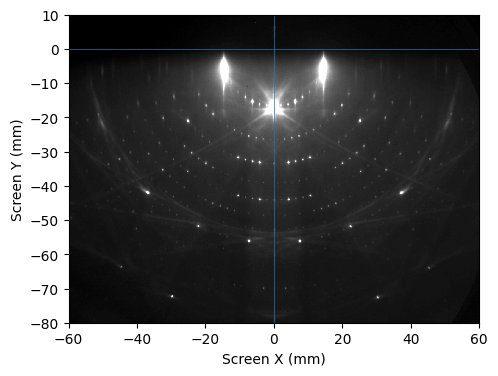

In [23]:
image_dir = Path("example_data")
image_path = image_dir / "Si_111_7x7_112_phi_00.raw"

rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")

# Rotate the image
rheed_image.ri.rotate(-0.4)

# Apply automatic center search again after rotation
rheed_image.ri.apply_image_center(auto_center=True)

rheed_image.ri.screen_roi_width = 60
rheed_image.ri.screen_roi_height = 80

# Use automatic levels adjustment
rheed_image.ri.plot_image(auto_levels=0.5)

plt.show()

## Prepare the 2D lattice

This RHEED image shows the pattern recorded from the Si(111) surface with the apparent (7x7) reconstruction.
First we can calculate the position of the (1x1) spots using the hexagonal 2D lattice with the 3.84 A lattice constant.

It should be also noted that this particular image was recorded for a electron beam aligned along [11-2] direction.

The lattice could be created by profiding basic vectors of the real space.

The `from_bulk_cubic` method allows to create the lattice simply by providing the bulk lattice constant, the `cubic_type`, and the `plane` (only low index planes are supported).

In [24]:
from xrheed.kinematics.lattice import Lattice

In [25]:
hex_lattice = Lattice([3.84, 0], [3.84*0.5, 3.325])
hex_lattice

a1 = [3.840, 0.000] A
a2 = [1.920, 3.325] A

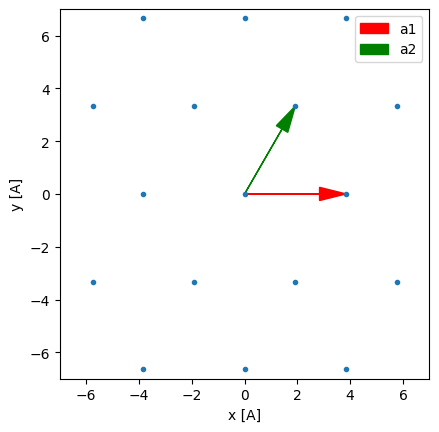

In [26]:
from xrheed.kinematics.lattice import Lattice

si_111_1x1 = Lattice.from_bulk_cubic(a=5.43, cubic_type="FCC", plane='111')

si_111_1x1.plot_real(space_size=7.0)
plt.show()

The x axis used in the lattice shown above is the same as in x-y-z sample geometry.

This means that incident electron beam is directed approximately along this x axis. What is [1-10] direction in that case.

The lattice should be rotated by 30 degrees to agree in the geometry used in this particular RHEED experiment.

Nonetheless, this step could be omitted, since the phi angle (sample azimuthal rotation) could be adjusted later in Ewald construction calculation.

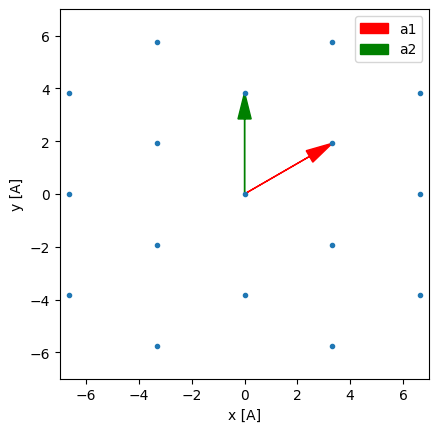

In [27]:
alpha = 30.0
si_111_1x1.rotate(alpha)
si_111_1x1.plot_real(space_size=7)
plt.show()

Each lattice has both real and inverse representation that are updated automatically.

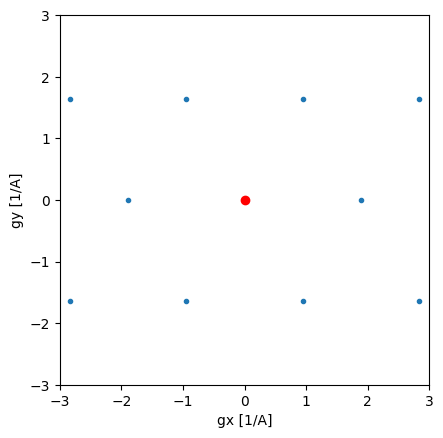

In [28]:
si_111_1x1.plot_inverse(space_size=3.0)
plt.show()

## Ewald construction

### RHEED experiment geometry

In the `xRHEED` software the following geometry is assumed.

![xRHEED geometry](../_static/xRHEED_geometry.svg)

To calculate the spot positions for a given lattice and experimental conditions, first we need to calculate the $\phi$ and $\theta$ angles for each point where Ewald sphere intersects with reciprocal lattice rods. 

Those angles are defined in similar way to the spherical coordinate system but, here $\theta$ is measured in respect to the $x$ axes (instead of $z$ as typically used).

### Ewald sphere in k space
The reciprocal lattice of a 2D real lattice has a form of regularly distributed rods that are normal to a crystal surface plane.

The diffraction spots are expected in the directions that are defined by the intersection points of the Ewald sphere and the rods, as shown on the sketch bellow.

![Ewald construction](../_static/Ewald_construction.svg)

While it is a common practice to show the sample, the screen and Ewald construction on the same sketch it is misleading while this mixes real and reciprocal dimensions.

That is why first we need to calculate the $\phi_i$ and $\theta_i$ angles using Ewald construction in k-space, and then use those angles in real space to calculate the $X_i$ and $Y_i$ spot positions on the RHEED screen.

### $\theta_i $ and $\phi_i$ calculation algorithm
1. Calculate the Ewald sphere radius $k_0$.
2. Generate the reciprocal rods in a (x,y) plane as $g_x$ , $g_y$.
3. Move the reciprocal lattice in $x$ direction to match the specular reflection with the crossing point of lattice rod and the sphere.
4. Select only those reciprocal lattice rods that are inside the Ewald sphere (their distance from the center of the sphere is smaller that it's radius). Left only those that could possibly cors the Ewald sphere.
5. Calculate the $k_r$ value (in general this value is calculated for each `i-th` point, althoug in some cases this is a common value for several points that belong to the same Laue's zone in a symmetric azimuthal orientation).
6. Calculate the $\theta_i = \sqrt{k_r}/ k$. 
7. The $\phi_i $ could be calculated as  $ \arccos(g_x/ k_r)$.

### Spot x, y positions
Having the $\theta_i$ values we can calculate the radius $\rho$ for each Laue's zone (or for each spot in asymmetric conditions). Here we use cylindrical coordinate system with the x-y plane on the RHEED screen.

Finally (on the screen coordinates $s_x$, $s_y$):

$s_x = \rho \cdot \cos(\phi)$ 

$s_y = \rho \cdot \sin(\phi)$ 



## Ewald class

Finally, having two necessary ingredients:
- loaded and aligned RHEED image,
- lattice object.

The spot position can be calculated using kinematic theory (Ewald construction) as shown below. 

In general the RHEED image is optional, however to calculate the spot position in an real experimental conditions 
the image is used to provide for example, screen-sample distance, screen scaling, incident theta angle.

Please note that, `Ewald` object creates a separate lattice for it's own purpose (this lattice could be easily scaled for precised matching).



In [29]:
from xrheed.kinematics.ewald import Ewald

In [30]:
ew_si_111 = Ewald(si_111_1x1, 
                  rheed_image)

ew_si_111

  Ewald Radius: 69.87 1/A,
  alpha: 0.00 deg,
  beta: 1.00 deg,
  lattice_scale: 1.00,
  screen_scale: 9.04 px/mm,
  screen_sample_distance: 309.2 mm,
  shift_x: 0.00 mm,
  shift_y: 0.00 mm,
  b1 = [1.89, -0.00] 1/A,
  b2 = [-0.94, 1.64] 1/A,

In [31]:
ew_si_111.calculate_ewald()
print(ew_si_111.sx)
print(ew_si_111.sy)

[-5.95550812e+01 -5.28452688e+01 -5.13962650e+01 -4.46663109e+01
 -3.67116179e+01 -2.97775406e+01 -2.20269707e+01 -1.48887703e+01
 -7.34232358e+00  4.50815221e-15  3.30477434e-16  7.34232358e+00
  1.48887703e+01  2.20269707e+01  2.97775406e+01  3.67116179e+01
  4.46663109e+01  5.28452688e+01  5.13962650e+01  5.95550812e+01]
[-43.28560254 -74.13556282  -5.270823   -58.52667557 -36.35401969
 -67.33312081 -46.73510667 -72.10253532 -51.14145012 -73.62371276
  -5.39710608 -51.14145012 -72.10253532 -46.73510667 -67.33312081
 -36.35401969 -58.52667557 -74.13556282  -5.270823   -43.28560254]


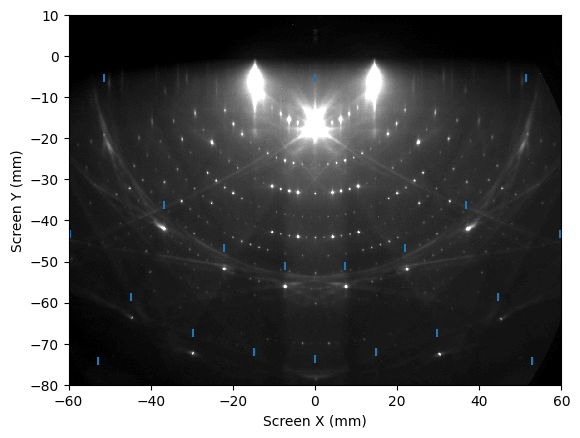

In [32]:
fig, ax = plt.subplots() 

ew_si_111.plot(ax=ax, 
               show_image=True,
               show_center_lines=False,
               auto_levels=1.0)
plt.show()

## Fine adjustment

As visible on the image above the incident angle is not set properly, also the image scaling sometimes needs to be adjusted as shown below.

There are two method available to adjust calculated spot position

### Adjust Ewald class
For temporary adjustments or relatively simple analysis it is recommended to set attributes: `beta`, `shift_x` and `shift_y`, `fine_scalling` in Ewald object directly.

 Those attributes are stored separately from the origin RHEED image.

 ### Adjust the RHEED image
If, for example, the `screen_scale` needs to be corrected this should be done directly on RHEED image object, but then the Ewald object has to be recrated. The same applies to the x/y shift of the RHEED image that was described in `Getting started` notebook.

In [33]:
ew_si_111

  Ewald Radius: 69.87 1/A,
  alpha: 0.00 deg,
  beta: 1.00 deg,
  lattice_scale: 1.00,
  screen_scale: 9.04 px/mm,
  screen_sample_distance: 309.2 mm,
  shift_x: 0.00 mm,
  shift_y: 0.00 mm,
  b1 = [1.89, -0.00] 1/A,
  b2 = [-0.94, 1.64] 1/A,

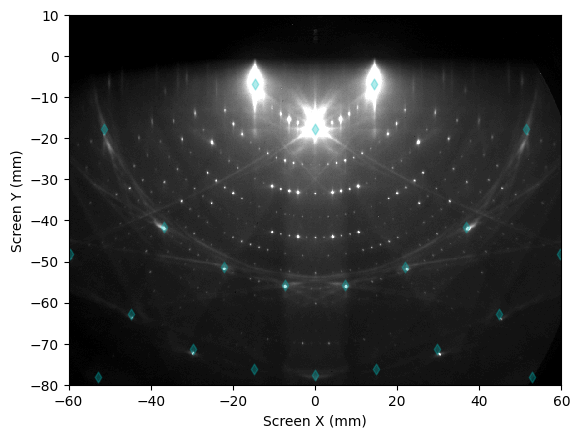

In [34]:
beta = 2.8
shift_y = -2.5
fine_scalling = 1.0

ew_si_111.beta = beta
ew_si_111.shift_y = shift_y
ew_si_111.fine_scalling = fine_scalling

ew_si_111.plot(auto_levels=1.0,
               marker='d',
               s=30,
               alpha=0.3,
               color='c')
plt.show()

### Adding the reconstruction
Having the (1x1) structure well adjusted we can add the (7x7) reconstruction.

In [35]:
si_111_7x7 = Lattice.from_surface_hex(a=3.84*7)
si_111_7x7.rotate(alpha)
si_111_7x7

a1 = [23.279, 13.440] A
a2 = [0.000, 26.879] A

Create Ewald object for new lattice, and copy already adjusted attributes.

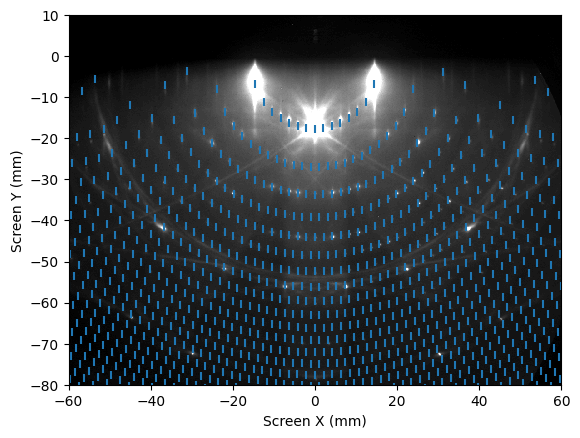

In [36]:
ew_si_111_7x7 = Ewald(si_111_7x7, rheed_image)

ew_si_111_7x7.beta = beta
ew_si_111_7x7.shift_y = shift_y

ew_si_111_7x7.plot(auto_levels=1.0)
plt.show()

## Final image
Finally, prepare and save a plot with both reconstructions.

For clarity, here we use high pass filtered image.

In [37]:
from xrheed.preparation.filters import high_pass_filter

sigma = 5.0 # in mm
sigma_px = sigma * rheed_image.ri.screen_scale
threshold = 0.8

hp_rheed_image = high_pass_filter(rheed_image, sigma=sigma, threshold=threshold)


In [1]:
cm = 1 / 2.4

fig, ax = plt.subplots(figsize=(14 * cm, 10 * cm), 
                       constrained_layout=True)

hp_rheed_image.ri.plot_image(ax=ax,
                             vmin=10,
                             vmax=22,
                             show_center_lines=False)

ew_si_111_7x7.plot(ax=ax, 
                   show_image=False,
                   auto_levels=1.0,
                   marker="|", 
                   s=10, 
                   alpha=0.7,
                   color="y"
                   )

ew_si_111.plot(ax=ax, 
               show_image=False, 
               marker="d", 
               s=40, 
               alpha=0.7,
               color="c")

ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-80, 0)
fig.set_dpi(100)
plt.show()
#fig.savefig()

NameError: name 'plt' is not defined